In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

In [2]:
from model_class.model_simply_traffic_lights import TrafficSimulation as sim

In [8]:
# Effect of density on flow rate for varying number of timesteps

# first def the function to be run in the multiprocessing (only one input argument (easier)), 
# ideally only one output as well 

def number_steps_sim( number_of_steps): 
    # def paras 
    densities = np.linspace(0, 1, 100)
    road_length = 70
    car_slow_down_prob = 0.1
    road_speed_limit = 9

    # 
    road_speed_limit_list = [road_speed_limit]*road_length
    traffic_light_list = []
    
    #
    flow_rates = np.zeros_like(densities) 
    
    for index,density in enumerate(densities): 
        ts = sim(road_speed_limit_list, traffic_light_list, density, car_slow_down_prob)

        for _ in range(number_of_steps): 
            ts.update() 
        
        flow_rate = ts.data_laps/number_of_steps
        flow_rates[index] = flow_rate

    return flow_rates 


In [57]:
num_cpu = mp.cpu_count() # get how many cpus on system 
pool = mp.Pool(processes=num_cpu)

## warning use a small number first, will take time for large values (20 is taken awhile on my system)
number_of_repeats = 5 # number of iteration for reruns, to compute mean and var, 

data_points  = 100 # np.linspace(0,1,100)
nts = [10, 50, 75, 100]#  1000, 10000]

# allocate mem, based on the number of data point and number of repeats.
flow_rates_by_steps = [np.zeros((number_of_repeats, data_points))]*len(nts) 

for i,n in enumerate( nts): 
    # run multiprocessing
    result = pool.map(number_steps_sim, [n]*number_of_repeats) 
    # reshape to np.array
    flow_rates_by_steps[i] = np.array(result).reshape((number_of_repeats, data_points))


In [36]:
def calculate_mean_var(results_data):
    # allocate mem for speed.
    mean_values = [None]*len(results_data)
    var_values  = [None]*len(results_data) 
    # compute the mean and var for each batch.
    for i,data in enumerate(results_data):
        mean_values[i] = np.mean(data, axis=0)
        var_values[i] =np.var(data, axis=0) 
    return mean_values, var_values

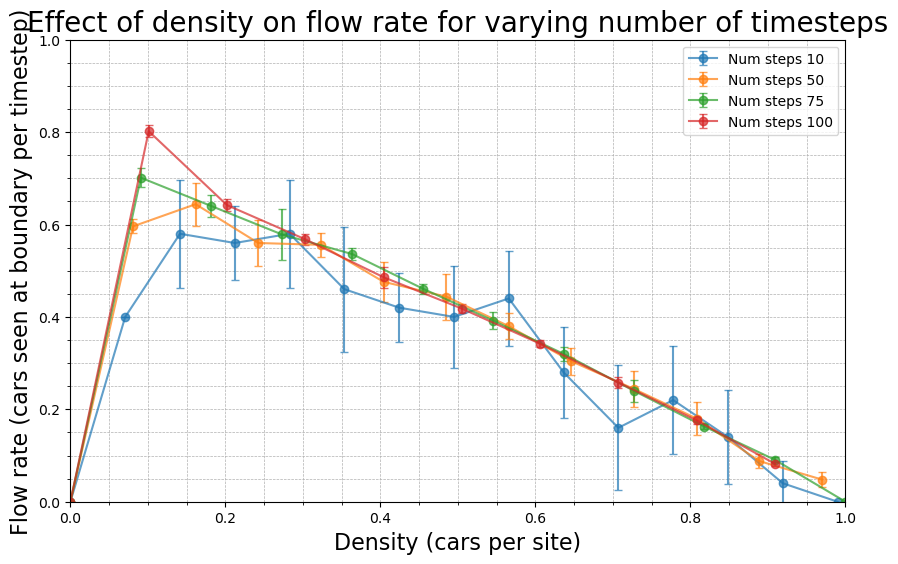

In [59]:
means,vars = calculate_mean_var(flow_rates_by_steps)
# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means):
    offset = 7+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 100)[::offset], mean[::offset], yerr=np.sqrt( vars[i] )[::offset] , alpha=0.7, fmt='-o', label=f'Num steps {nts[i]}',capsize=3)
plt.xlabel(f'Density (cars per site)', size=16)
plt.ylabel('Flow rate (cars seen at boundary per timestep)', size=16)
plt.title('Effect of density on flow rate for varying number of timesteps',size=20)
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [33]:
## Position of Traffic lights
def pos_traffic_sim(light_pos): 


    nt = 100
    red_time = 6  # giving pdestrians roughly 25s to cross
    green_time = red_time + 15 # gives cars around a minute between red lights
    starting_time = 0
    car_slow_down_prob = 0.127  # standard value for error from some paper (need ref)
    region_lengths = np.array([240])  # only one speed limit everywhere
    region_speed_limits = [14]  # setting speed limit to roughly 30mph
    
    region_lengths = [14]*240
    #n_cars_list = np.linspace(1,sum(region_lengths), 20).astype(int)
    #densities = n_cars_list/sum(region_lengths)
    
    varying_light_positions = np.linspace(0, sum(region_lengths) - 1, 5).astype(int)

    #
    traffic_light_list = [(light_pos, green_time, red_time, starting_time, False)]
    
    #
    densities = np.linspace(0, 1, 100)
    flow_rates = np.zeros_like(densities) 
    
    for index,density in enumerate(densities): 
        ts = sim(region_lengths, traffic_light_list, density, car_slow_down_prob)
        
        for _ in range(nt): 
            ts.update() 
        
        flow_rate = ts.data_laps/nt
        flow_rates[index] = flow_rate

    return flow_rates 



In [39]:
num_cpu = mp.cpu_count() # get how many cpus on system 
pool = mp.Pool(processes=num_cpu)

##
region_lengths = np.array([240])  # only one speed limit everywhere
varying_light_positions = np.linspace(0, sum(region_lengths) - 1, 5).astype(int)

N = len(varying_light_positions)

## warning use a small number first, will take time for large values (20 is taken awhile on my system)
number_of_repeats = 5 # number of iteration for reruns, to compute mean and var, 

data_points  = 100 # np.linspace(0,1,100)

# allocate mem, based on the number of data point and number of repeats.
flow_rates_by_steps = [np.zeros((number_of_repeats, data_points))]*N

for i,n in enumerate( varying_light_positions): 
    # run multiprocessing
    result = pool.map(pos_traffic_sim, [n]*number_of_repeats) 
    # reshape to np.array
    flow_rates_by_steps[i] = np.array(result).reshape((number_of_repeats, data_points))

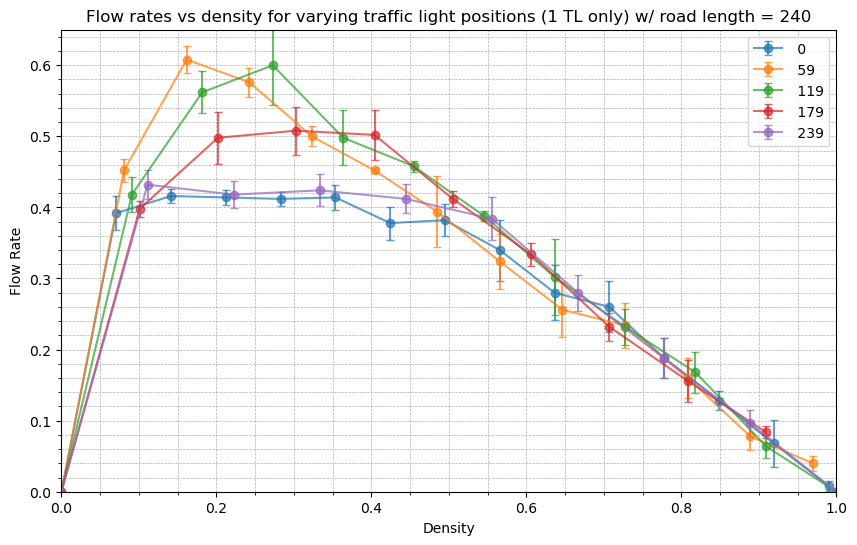

In [44]:
means,vars = calculate_mean_var(flow_rates_by_steps)
# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means):
    offset = 7 + (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 100)[::offset], mean[::offset], yerr=np.sqrt( vars[i] )[::offset] , alpha=0.7, fmt='-o', label=f' {varying_light_positions[i]}',capsize=3)
plt.title("Flow rates vs density for varying traffic light positions (1 TL only) w/ road length = 240")
plt.xlabel("Density")
plt.ylabel("Flow Rate")
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,0.65])
plt.show()

In [62]:
## Red / Green cycle times
def red_green_sim(red_time): 
    nt = 200
    starting_time = 0
    car_slow_down_prob = 0.127  # standard value for error from some paper (need ref)
    region_lengths = np.array([240])  # only one speed limit everywhere
    region_speed_limits = [14]  # setting speed limit to roughly 30mph
    light_positions = [140]
    
    region_lengths = [14]*240

    #
    red_time = red_time
    green_time = red_time + 15
    traffic_light_list = [(light_positions[0], green_time, red_time, starting_time, False)]
    
    #
    densities = np.linspace(0, 1, 20)
    flow_rates = np.zeros_like(densities) 
    
    for index,density in enumerate(densities): 
        ts = sim(region_lengths, traffic_light_list, density, car_slow_down_prob)
        
        for _ in range(nt): 
            ts.update() 
        
        flow_rate = ts.data_laps/nt
        flow_rates[index] = flow_rate

    return flow_rates 


In [63]:
num_cpu = mp.cpu_count() # get how many cpus on system 
pool = mp.Pool(processes=num_cpu)

##
region_lengths = np.array([240])  # only one speed limit everywhere
red_time_list = np.linspace(5, 25 + 1, 5).astype(int)

N = len(varying_light_positions)

## warning use a small number first, will take time for large values (20 is taken awhile on my system)
number_of_repeats = 10 # number of iteration for reruns, to compute mean and var, 

data_points  = 20 # np.linspace(0,1,100)

# allocate mem, based on the number of data point and number of repeats.
flow_rates_by_steps = [np.zeros((number_of_repeats, data_points))]*N

for i,n in enumerate( red_time_list): 
    # run multiprocessing
    result = pool.map(red_green_sim, [n]*number_of_repeats) 
    # reshape to np.array
    flow_rates_by_steps[i] = np.array(result).reshape((number_of_repeats, data_points))

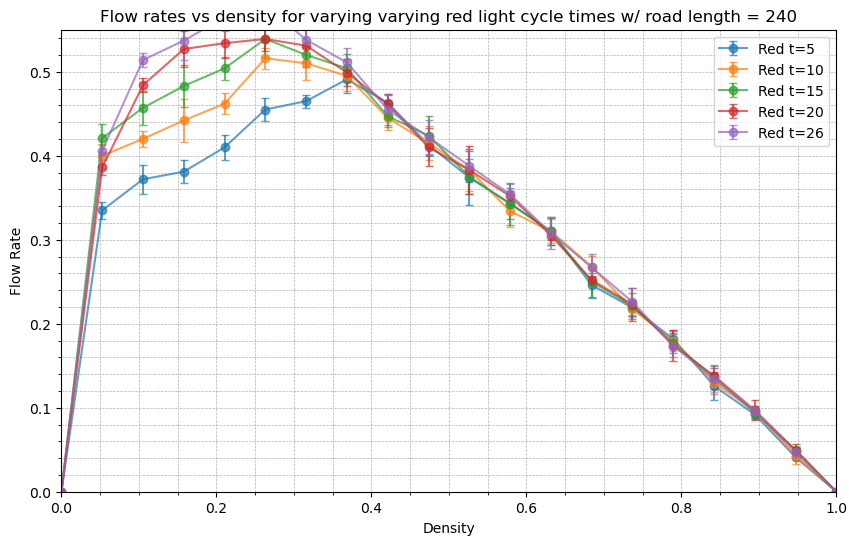

In [68]:
means,vars = calculate_mean_var(flow_rates_by_steps)
# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], yerr=np.sqrt( vars[i] )[::offset] , alpha=0.7, fmt='-o', label=f'Red t={red_time_list[i]}',capsize=3)
plt.title("Flow rates vs density for varying varying red light cycle times w/ road length = 240")
plt.xlabel("Density")
plt.ylabel("Flow Rate")
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,0.55])
plt.show()

In [66]:
## Green cycle times
def green_sim(green_additional_time): 
    nt = 200
    starting_time = 0
    car_slow_down_prob = 0.127  # standard value for error from some paper (need ref)
    region_lengths = np.array([240])  # only one speed limit everywhere
    region_speed_limits = [14]  # setting speed limit to roughly 30mph
    light_positions = [140]
    red_time = 6

    
    region_lengths = [14]*240

    #
    green_time = red_time + green_additional_time
    traffic_light_list = [(light_positions[0], green_time, red_time, starting_time, False)]
    
    #
    densities = np.linspace(0, 1, 20)
    flow_rates = np.zeros_like(densities) 
    
    for index,density in enumerate(densities): 
        ts = sim(region_lengths, traffic_light_list, density, car_slow_down_prob)
        
        for _ in range(nt): 
            ts.update() 
        
        flow_rate = ts.data_laps/nt
        flow_rates[index] = flow_rate

    return flow_rates 


In [67]:
num_cpu = mp.cpu_count() # get how many cpus on system 
pool = mp.Pool(processes=num_cpu)

##
region_lengths = np.array([240])  # only one speed limit everywhere
green_time_diff = np.arange(10, 30 + 1, 5).astype(int)


N = len(varying_light_positions)

## warning use a small number first, will take time for large values (20 is taken awhile on my system)
number_of_repeats = 5 # number of iteration for reruns, to compute mean and var, 

data_points  = 20 # np.linspace(0,1,100)

# allocate mem, based on the number of data point and number of repeats.
flow_rates_by_steps = [np.zeros((number_of_repeats, data_points))]*N

for i,n in enumerate( green_time_diff): 
    # run multiprocessing
    result = pool.map(green_sim, [n]*number_of_repeats) 
    # reshape to np.array
    flow_rates_by_steps[i] = np.array(result).reshape((number_of_repeats, data_points))

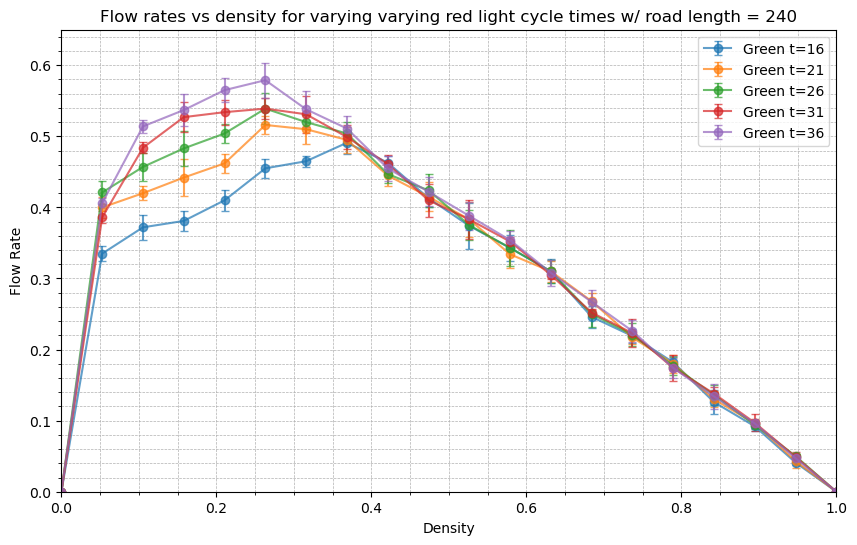

In [70]:
means,vars = calculate_mean_var(flow_rates_by_steps)
# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], yerr=np.sqrt( vars[i] )[::offset] , alpha=0.7, fmt='-o', label=f'Green t={6+green_time_diff[i]}',capsize=3)
plt.title("Flow rates vs density for varying varying red light cycle times w/ road length = 240")
plt.xlabel("Density")
plt.ylabel("Flow Rate")
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,0.65])
plt.show()

In [71]:
## Two traffic light 
def two_traffic_light(second_light_pos): 
    nt = 200
    starting_time = 0
    car_slow_down_prob = 0.127  # standard value for error from some paper (need ref)
    region_lengths = np.array([240])  # only one speed limit everywhere
    region_speed_limits = [14]  # setting speed limit to roughly 30mph
    light_positions = [140]
    red_time = 6
    green_time = red_time + 15 # gives cars around a minute between red lights

    region_lengths = [14]*240

    traffic_light_list = [(light_positions[0], green_time, red_time, starting_time, False),
                         (second_light_pos, green_time, red_time, starting_time, False)]
    
    #
    densities = np.linspace(0, 1, 20)
    flow_rates = np.zeros_like(densities) 
    
    for index,density in enumerate(densities): 
        ts = sim(region_lengths, traffic_light_list, density, car_slow_down_prob)
        
        for _ in range(nt): 
            ts.update() 
        
        flow_rate = ts.data_laps/nt
        flow_rates[index] = flow_rate

    return flow_rates 


In [79]:
num_cpu = mp.cpu_count() # get how many cpus on system 
pool = mp.Pool(processes=num_cpu)

##
region_lengths = np.array([240])  # only one speed limit everywhere
green_time_diff = np.arange(10, 30 + 1, 5).astype(int)


N = len(varying_light_positions)
light2_positions = np.linspace(20, 240/2 + 1, 5).astype(int)

## warning use a small number first, will take time for large values (20 is taken awhile on my system)
number_of_repeats = 10 # number of iteration for reruns, to compute mean and var, 

data_points  = 20 # np.linspace(0,1,100)

# allocate mem, based on the number of data point and number of repeats.
flow_rates_by_steps = [np.zeros((number_of_repeats, data_points))]*N

for i,n in enumerate( light2_positions): 
    # run multiprocessing
    result = pool.map(green_sim, [n]*number_of_repeats) 
    # reshape to np.array
    flow_rates_by_steps[i] = np.array(result).reshape((number_of_repeats, data_points))

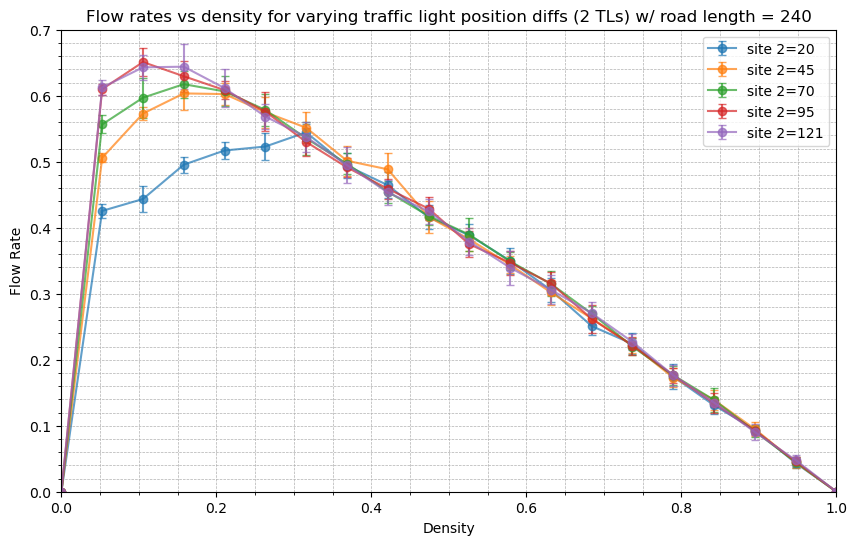

In [80]:
means,vars = calculate_mean_var(flow_rates_by_steps)
# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means):
    offset = 1 #+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 20)[::offset], mean[::offset], yerr=np.sqrt( vars[i] )[::offset] , alpha=0.7, fmt='-o', label=f'site 2={light2_positions[i]}',capsize=3)
plt.title("Flow rates vs density for varying traffic light position diffs (2 TLs) w/ road length = 240")
plt.xlabel("Density")
plt.ylabel("Flow Rate")
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,0.7])
plt.show()